In this notebook I will examine the likelihood pdf of the group multiplicity function (GMF) from Manodeep's mock catalogs. I will quantify the divergence between the likelihood pdf and a $pseudo$-Gaussian likelihood described by the covariance matrix.

In [70]:
import os
import numpy as np
import pickle
import corner as DFM

import env
import util as UT
import nongauss as NG

In [2]:
from skl_groups.divergences import KNNDivergenceEstimator
from skl_groups.features import Features

In [3]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Lets read in Manodeep's mock catalog. More specifically, I will read in 200 mocks from `n_run` HOD parameter. 

In [7]:
n_run = 1
dir = ''.join([UT.dat_dir(), 'manodeep/run_', str(n_run).zfill(4), '/']) # directory 

In [12]:
gmfs = []
for ireal in range(1,51): # loop through the 50 realizations
    for ibox in range(4): # loop through the 4 cut outs
        f = ''.join([dir, 'out2_40', str(ireal).zfill(2), '_irot_', str(ibox), '_gmf_geometry_binned.dat'])
        gmf_i, nbin_low, nbin_high = np.loadtxt(f, unpack=True, usecols=[0,1,2])
        gmfs.append(gmf_i)
gmfs = np.array(gmfs)
n_mock = gmfs.shape[0]

In [15]:
nbins = np.concatenate([nbin_low, [nbin_high[-1]]])
print nbins

[   5.    7.   10.   14.   20.   33.   53.   85.  220.]


Plot of the 200 GMFs

(0.0, 250.0)

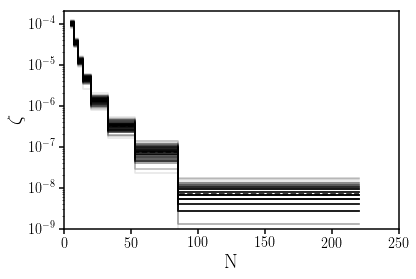

In [47]:
fig = plt.figure() 
sub = fig.add_subplot(111)
for i in range(n_mock): 
    xx, yy = UT.bar_plot(nbins, gmfs[i,:])
    sub.plot(xx, yy, c='k', alpha=0.1)
xx, yy = UT.bar_plot(nbins, np.sum(gmfs, axis=0)/float(n_mock))
sub.plot(xx, yy, c='k', ls='--')
sub.set_ylabel('$\zeta$', fontsize=20)
sub.set_yscale("log")
sub.set_ylim([1e-9, 2e-4])
sub.set_xlabel('N', fontsize=20)
sub.set_xlim([0., 250.])

What does the covariance matrix look like? 

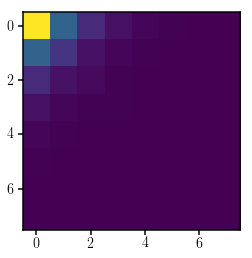

In [24]:
plt.imshow(np.cov(gmfs.T))

Now lets whiten the data

In [111]:
gmf_avg = (np.sum(gmfs, axis=0)/float(n_mock))
gmfs_white, W = NG.whiten(gmfs - gmf_avg)#, method='stddev_scale')

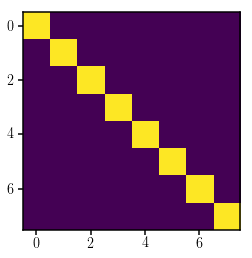

In [112]:
C_gmf = np.cov(gmfs_white.T)
plt.imshow(C_gmf)

Now we quantify the discrepancy between the GMF likelihood estimated from the mocks with a mutivariate Gaussian (Gaussian $pseudo$-likelihood). We use kNN divergence estimators. 

In [113]:
mvn = np.random.multivariate_normal
gauss = mvn(np.zeros(len(gmf_avg)), C_gmf, size=1000) # reference Gaussian distribution

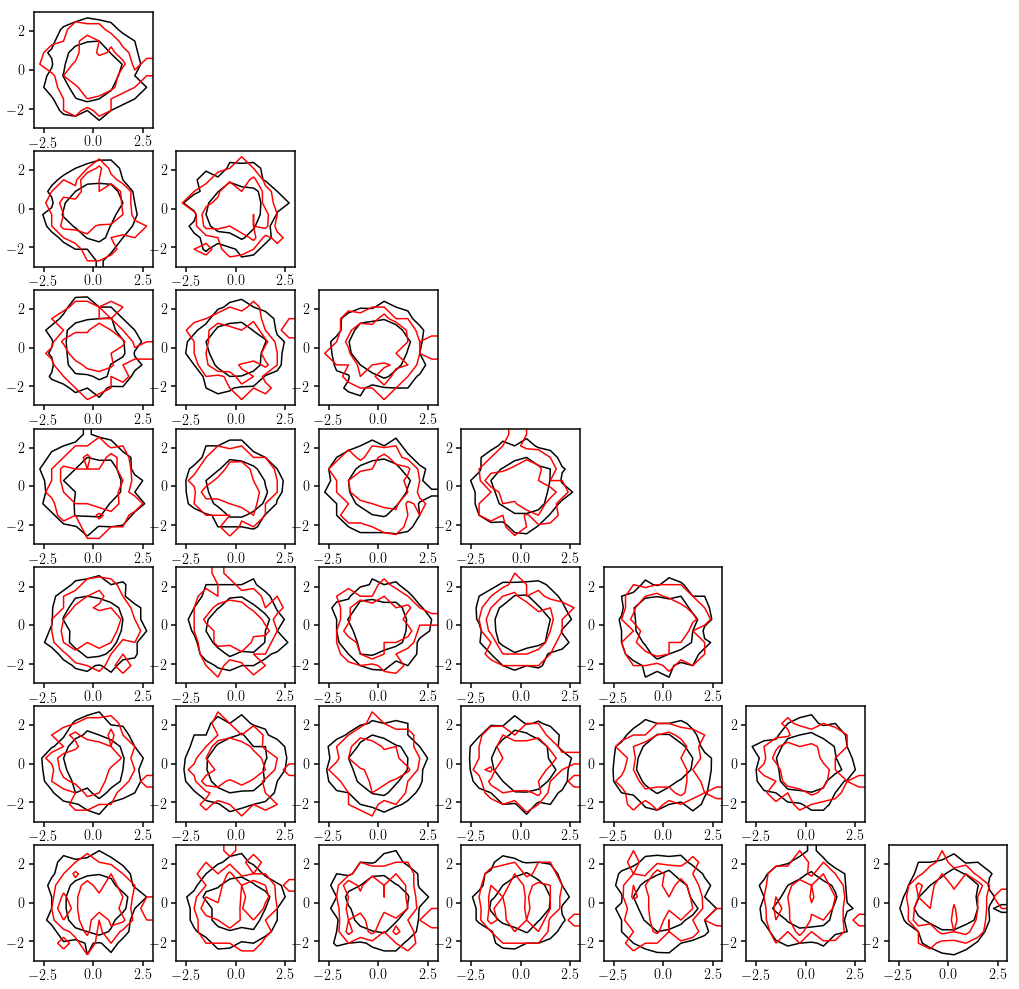

In [114]:
fig = plt.figure(figsize=(20,20))
for i in range(len(gmf_avg)): 
    for j in range(len(gmf_avg)): 
        if i > j: 
            sub = fig.add_subplot(len(gmf_avg), len(gmf_avg), len(gmf_avg)*i+j+1)
            DFM.hist2d(gauss[:,i], gauss[:,j], color='k',
                       levels=[0.68, 0.95], range=[[-3.,3.], [-3.,3]], bins=10,
                       plot_datapoints=False, fill_contours=False, plot_density=False, ax=sub) 
            #sub.scatter(gauss[:,i], gauss[:,j])
            DFM.hist2d(gmfs_white[:,i], gmfs_white[:,j], color='r',
                       levels=[0.68, 0.95], range=[[-3.,3.], [-3.,3]], bins=10,
                       plot_datapoints=False, fill_contours=False, plot_density=False, ax=sub) 
            #sub.scatter(gmfs_white[:,i], gmfs_white[:,j])
            sub.set_xlim([-3., 3.])
            sub.set_ylim([-3., 3.])

In [115]:
div_knns = []
n = 200 
for i in range(n): 
    gauss = mvn(np.zeros(len(gmf_avg)), C_gmf, size=1000) # reference Gaussian distribution
    kNN = KNNDivergenceEstimator(div_funcs=["renyi:.5"], Ks=[1,2,3,4,5,6], version='slow', clamp=False)
    feat = Features([gmfs_white, gauss])
    div_knn_i = kNN.fit_transform(feat)
    if i == 0: 
        div_knn = div_knn_i
    else: 
        div_knn += div_knn_i #kNN.fit_transform(feat)
    div_knns.append(div_knn_i)
div_knn /= float(n)

In [116]:
print div_knn

[[[[-0.         -0.1512645 ]
   [ 0.00140842 -0.        ]]

  [[-0.         -0.2183359 ]
   [ 0.04609895 -0.        ]]

  [[-0.         -0.25943458]
   [ 0.0809873  -0.        ]]

  [[-0.         -0.25017542]
   [ 0.10683704 -0.        ]]

  [[-0.         -0.25908443]
   [ 0.12927766 -0.        ]]

  [[-0.         -0.26887655]
   [ 0.14928077 -0.        ]]]]


In [117]:
div_1nn_1to2, div_2nn_1to2, div_3nn_1to2, div_4nn_1to2, div_5nn_1to2, div_6nn_1to2 = [], [], [], [], [], []
for i in range(n): 
    gauss = mvn(np.zeros(len(gmf_avg)), C_gmf, size=1000) # reference Gaussian distribution
    gauss2 = mvn(np.zeros(len(gmf_avg)), C_gmf, size=len(gmfs))
    kNN = KNNDivergenceEstimator(div_funcs=["renyi:.5"], Ks=[1,2,3,4,5,6], version='slow', clamp=False)
    feat = Features([gauss2, gauss])
    div_knn_i = kNN.fit_transform(feat)
    div_1nn_1to2.append(div_knn_i[0][0][0][1])
    div_2nn_1to2.append(div_knn_i[0][1][0][1])
    div_3nn_1to2.append(div_knn_i[0][2][0][1])
    div_4nn_1to2.append(div_knn_i[0][3][0][1])
    div_5nn_1to2.append(div_knn_i[0][4][0][1])
    div_6nn_1to2.append(div_knn_i[0][5][0][1])
div_knn_1to2 = [div_1nn_1to2, div_2nn_1to2, div_3nn_1to2, div_4nn_1to2, div_5nn_1to2, div_6nn_1to2]

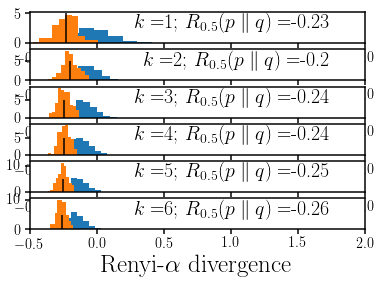

In [122]:
fig = plt.figure(figsize=())
for i in range(1, 7):
    sub = fig.add_subplot(6,1,i)
    _ = sub.hist(div_knn_1to2[i-1], normed=True)#, range=[-1, 2.], bins=60)
    _ = sub.hist([div[0][i-1][0][1] for div in div_knns], normed=True)
    #print div_knn[0][0][0][1]
    sub.vlines(div_knn[0][i-1][0][1], 0, 5)
    sub.set_xlim([-0.5, 2.])
    sub.text(0.9, 0.9, '$k=$'+str(i)+'; $R_{0.5}(p \parallel q) = $'+str(round(div_knn[0][i-1][0][1],2)), ha='right', va='top', transform=sub.transAxes, fontsize=20)
sub.set_xlabel(r'Renyi-$\alpha$ divergence', fontsize=25)

In [119]:
div_knns = []
n = 200 
for i in range(n): 
    gauss = mvn(np.zeros(len(gmf_avg)), C_gmf, size=1000) # reference Gaussian distribution
    kNN = KNNDivergenceEstimator(div_funcs=["kl"], Ks=[1,2,3,4,5,6], version='slow', clamp=False)
    feat = Features([gmfs_white, gauss])
    div_knn_i = kNN.fit_transform(feat)
    if i == 0: 
        div_knn = div_knn_i
    else: 
        div_knn += div_knn_i #kNN.fit_transform(feat)
    div_knns.append(div_knn_i)
div_knn /= float(n)

In [120]:
div_1nn_1to2, div_2nn_1to2, div_3nn_1to2, div_4nn_1to2, div_5nn_1to2, div_6nn_1to2 = [], [], [], [], [], []
for i in range(1000): 
    gauss = mvn(np.zeros(len(gmf_avg)), C_gmf, size=1000) # reference Gaussian distribution
    gauss2 = mvn(np.zeros(len(gmf_avg)), C_gmf, size=len(gmfs))
    kNN = KNNDivergenceEstimator(div_funcs=["kl"], Ks=[1,2,3,4,5,6], version='slow', clamp=False)
    feat = Features([gauss2, gauss])
    div_knn_i = kNN.fit_transform(feat)
    div_1nn_1to2.append(div_knn_i[0][0][0][1])
    div_2nn_1to2.append(div_knn_i[0][1][0][1])
    div_3nn_1to2.append(div_knn_i[0][2][0][1])
    div_4nn_1to2.append(div_knn_i[0][3][0][1])
    div_5nn_1to2.append(div_knn_i[0][4][0][1])
    div_6nn_1to2.append(div_knn_i[0][5][0][1])

div_knn_1to2 = [div_1nn_1to2, div_2nn_1to2, div_3nn_1to2, div_4nn_1to2, div_5nn_1to2, div_6nn_1to2]

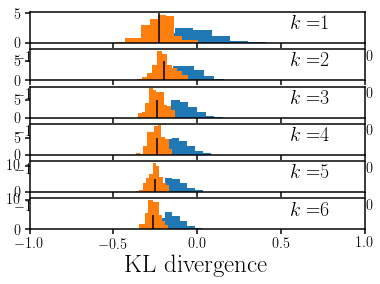

In [121]:
fig = plt.figure()
for i in range(1, 7):
    sub = fig.add_subplot(6,1,i)
    _ = sub.hist(div_knn_1to2[i-1], normed=True)#, range=[-1., 2.], bins=60)
    _ = sub.hist([div[0][i-1][0][1] for div in div_knns], normed=True)
    sub.vlines(div_knn[0][i-1][0][1], 0, 5)
    sub.set_xlim([-1., 1.])    
    sub.text(0.9, 0.9, '$k=$'+str(i), ha='right', va='top', transform=sub.transAxes, fontsize=20)
sub.set_xlabel(r'KL divergence', fontsize=25)